In [824]:
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from config import Conf
import os
from tqdm import tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [825]:
load_dir = '/Users/jo/notebooks_paper/run_data/2024-02-05/Untitled/18:37'

In [826]:
def partition_trials(arr, t_axis=1):
    arr_trial = np.array_split(arr, arr.shape[t_axis]//Conf.trial_len, axis=t_axis)
    arr_trial = np.stack(arr_trial, axis=1)
    return arr_trial

def partition_all(arrs, t_axis=1):
    return [partition_trials(arr, t_axis=t_axis) for arr in arrs]

def argmax_all(arrs, onehot_axis=-1):
    return [np.argmax(arr, axis=onehot_axis) for arr in arrs]

def unpack_data_dict(data_dict):
    return data_dict['inputs'], data_dict['targets'], data_dict['choices'], data_dict['ground_truth'], data_dict['p_A_high'], data_dict['hidden']

def detect_anomalies(thresholds = Conf.threshold):
    # thresholds = 4.99
    if thresholds is not None:
        thresholds = thresholds - 0.01
        anomaly = hidden_trial > thresholds
        return np.any(anomaly, axis=(1,2,3))
    else:
        return []

504, 1000, 5, 256
504, 256, n_p_bins, 5
3, 9, n_p_bins, 5


In [827]:
import h5py
from plotting import *

def list_all_datasets(h5file, prefix=''):
    print('here')
    print([k for k in h5file.keys()])
    for key in h5file.keys():
        item = h5file[key]
        path = f"{prefix}/{key}"
        if isinstance(item, h5py.Dataset):
            # This is a dataset
            print(f"Dataset: {path}")
        elif isinstance(item, h5py.Group):
            # This is a group, recurse into it
            list_all_datasets(item, path)

with h5py.File(os.path.join(load_dir, 'data_test.h5'), 'r') as file:
    # Access the dataset
    list_all_datasets(file)
    print([k for k in file.keys()])

    # Determine chunk size
    num_trials_test = 40 # Conf.num_trials_test
    chunk_size_trial = 40
    chunk_size_t = num_trials_test * Conf.trial_len
    # n_chunks = Conf.num_epochs_test  
    lens = []
    for key in file.keys():
        lens.append(file[key].shape[1])
        print(key, file[key].shape[1])
    lens = np.unique(lens)
    n_chunks = np.min(lens) // chunk_size_trial
    # Read and process in chunks
    print('n_chunks:', n_chunks)
    means, bin_counts = [], []
    for i in range(0, n_chunks):
        # Read a chunk
        data_dict = {}
        for key in file.keys():
            item = file[key]
            chunk_size = chunk_size_t if item.shape[1] == n_chunks * chunk_size_t else chunk_size_trial

            slices = [slice(None)] * len(item.shape)
            # Replace the slice in the specified axis with the new range
            start = i * chunk_size
            slices[1] = slice(start, start + chunk_size)
            slices = tuple(slices)
            data_dict[key] = item[slices]

        inputs, targets, choices, ground_truth, p_A, hiddens = unpack_data_dict(data_dict)
        
        print([x.shape for x in [inputs, choices, targets, hiddens]])
        inputs_trial, choices_trial, targets_trial, hidden_trial = partition_all([inputs, choices, targets, hiddens])
        print(inputs_trial.shape, choices_trial.shape, targets_trial.shape, hidden_trial.shape)

        # inputs_arg_trial, choices_arg_trial, targets_arg_trial = argmax_all([inputs_trial, choices_trial, targets_trial])
        # print(inputs_arg_trial.shape, choices_arg_trial.shape, targets_arg_trial.shape)

        # plot_trials(inputs, ground_truth, targets, choices, p_A, fname=f'panel_{i}_h5.png', trials=15, b=0)

        if i == 0:
            x_arg_trial = np.argmax(inputs_trial[:,:Conf.x_dim,:], axis=-1)[:,0,:]
            x_arg_trial = np.repeat(x_arg_trial[:, np.newaxis, :], inputs_trial.shape[1], axis=1)

        anomalous_batches = detect_anomalies()
        mean, bin_count = get_means(p_A, x_arg_trial, hidden_trial, anomalous_batches, n_p_bins=20 if Conf.reward_prob == 0.8 else 2)
        means.append(mean)
        bin_counts.append(bin_count)
        # plot_average_layout_hists(p_A, inputs_arg_trial, hidden_trial, anomalous_batches, neur_ids=[235])

here
['choices', 'ground_truth', 'hidden', 'inputs', 'p_A_high', 'targets']
Dataset: /choices
Dataset: /ground_truth
Dataset: /hidden
Dataset: /inputs
Dataset: /p_A_high
Dataset: /targets
['choices', 'ground_truth', 'hidden', 'inputs', 'p_A_high', 'targets']
choices 160
ground_truth 160
hidden 160
inputs 160
p_A_high 40
targets 160
n_chunks: 1


KeyError: 'targets_masked_masked_masked'

In [ ]:
def swap_unique_elements(arr, layouts):
    if layouts.shape[1] != 2:
        raise ValueError('Layouts shape must be (n_batches, 2)')
    if layouts.shape[0] != arr.shape[0]:
        raise ValueError('Layouts shape[0] must match arr shape[0]')
    
    arr = arr.copy()
    for row, layout in zip(arr, layouts):
        a, b = layout[0], layout[1]
        a_idx = np.where(row == a)[0]
        b_idx = np.where(row == b)[0]

        row[a_idx], row[b_idx] = b, a

    return arr

In [874]:
layouts = x_arg_trial[:,0,1:3]

def train_decoders(hiddens, targets, layouts, exclude_batch_idxs=None, n_class=None, T=None, **kwargs):
    if exclude_batch_idxs is not None:
        hiddens_masked = np.delete(hiddens.copy(), exclude_batch_idxs, axis=0)
        targets_masked = np.delete(targets.copy(), exclude_batch_idxs, axis=0)
        layouts_masked = np.delete(layouts.copy(), exclude_batch_idxs, axis=0)
    else:
        hiddens_masked = hiddens.copy()
        targets_masked = targets.copy()
        layouts_masked = layouts.copy()
    
    accuracies, conf_matrices, chance = [], [], []
    y_tests, y_preds = [], []

    if hiddens.ndim != 3:
        raise ValueError('hiddens must be a 3D array with shape (n_batches, n_steps, n_neurons)')
    if targets.ndim not in [1,2]:
        raise ValueError('targets must be a 1D or 2D array with shape (n_batches, ) or (n_batches, n_steps)')
    
    if T is None or T > hiddens_masked.shape[1]: T = hiddens_masked.shape[1]
    conf_labels = np.unique(targets_masked) if n_class is None else np.arange(n_class)
    print(conf_labels)
    print(T)

    if set(np.unique(targets_masked)).issubset([True, False]):
        multiclass = False
    else:
        multiclass = True
    print(f'Using multiclass: {multiclass}')


    for step in tqdm(range(T)):
        # y = A_good[:, step].ravel()
        if targets_masked.ndim == 1:
            y = targets_masked
        else:
            y = targets_masked[:,step].ravel()
        X = hiddens_masked[:,step]

        print(X.shape, y.shape)
        X_train, X_test, y_train, y_test, layouts_train, layouts_test = train_test_split(X, y, layouts_masked, test_size=0.2, random_state=40)

        if np.unique(y_test).size < 2:
            accuracies.append(np.nan)
            chance.append(np.nan)
            continue
        
        # # Optionally, standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Define and train the logistic regression model
        model = LogisticRegression(solver='lbfgs', class_weight='balanced', **kwargs)
        model.fit(X_train_scaled, y_train)

        # Predictions
        y_pred = model.predict(X_test_scaled)
        y_tests.append(y_test)
        y_preds.append(y_pred)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred, labels=conf_labels, normalize='true')

        accuracies.append(accuracy)
        conf_matrices.append(conf_matrix)
        chance.append(1 / len(np.unique(y_test)))

        # print(f"Step {step} accuracy: {accuracy}")
        # print(f"Confusion Matrix:\n{conf_matrix}")
        # print(f"Classification Report:\n{report}")
    return accuracies, conf_matrices, chance, (layouts_test, np.array(y_tests), np.array(y_preds))
    

def plot_decoding_accuracy(accuracies, chance=None, T=None, n_class=None, title=None):
    T = len(accuracies) if T is None else T

    if chance is not None:
        plt.plot(chance * np.ones(T), 'r--', label='Chance')
    elif n_class is not None:
        chance = 1 / n_class
        plt.hlines(chance, 0, T, 'r', 'dashed', label='Chance')
    plt.plot(accuracies, 'b', linewidth=2, label='Decoding accuracy')
    plt.xticks(range(0,T,Conf.trial_len), range(0,T,Conf.trial_len))
    plt.xlim([0, T])
    plt.ylim([0, 1.01])
    plt.grid(True, 'major')
    plt.ylabel('Decoding accuracy')
    plt.xlabel('Step')
    if title is not None: plt.title(title)
    plt.legend()

In [904]:
def train_decoders_looped(hiddens, targets, layouts, train_steps=None, exclude_batch_idxs=None, n_class=None, T=None, **kwargs):
    if exclude_batch_idxs is not None:
        include_batch_idxs = np.array(list(set(range(hiddens.shape[0])) - set(exclude_batch_idxs))
        hiddens_masked = hiddens.copy()[include_batch_idxs]
        targets_masked = targets.copy()[include_batch_idxs]
        layouts_masked = layouts.copy()[include_batch_idxs]
    else:
        hiddens_masked = hiddens.copy()
        targets_masked = targets.copy()
        layouts_masked = layouts.copy()
    
    accuracies, conf_matrices, chance = [], [], []
    y_tests, y_preds = [], []

    if hiddens.ndim != 3:
        raise ValueError('hiddens must be a 3D array with shape (n_batches, n_steps, n_neurons)')
    if targets.ndim not in [1,2]:
        raise ValueError('targets must be a 1D or 2D array with shape (n_batches, ) or (n_batches, n_steps)')
    
    if T is None or T > hiddens_masked.shape[1]: T = hiddens_masked.shape[1]
    conf_labels = np.unique(targets_masked) if n_class is None else np.arange(n_class)
    print(conf_labels)
    print(T)

    if set(np.unique(targets_masked)).issubset([True, False]):
        multiclass = False
    else:
        multiclass = True
    print(f'Using multiclass: {multiclass}')


    for step in tqdm(range(T)):
        # y = A_good[:, step].ravel()
        if targets_masked.ndim == 1:
            y = targets_masked
        else:
            y = targets_masked[:,step].ravel()
        X = hiddens_masked[:,step]

        print(X.shape, y.shape)
        X_train, X_test, y_train, y_test, layouts_train, layouts_test = train_test_split(X, y, layouts_masked, test_size=0.2, random_state=40)

        if np.unique(y_test).size < 2:
            accuracies.append(np.nan)
            chance.append(np.nan)
            continue
        
        # # Optionally, standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Define and train the logistic regression model
        model = LogisticRegression(solver='lbfgs', class_weight='balanced', **kwargs)
        model.fit(X_train_scaled, y_train)

        # Predictions
        y_pred = model.predict(X_test_scaled)
        y_tests.append(y_test)
        y_preds.append(y_pred)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred, labels=conf_labels, normalize='true')

        accuracies.append(accuracy)
        conf_matrices.append(conf_matrix)
        chance.append(1 / len(np.unique(y_test)))


1

In [913]:
dddd

In [ ]:
action = choices[:,:,Conf.x_dim + Conf.r_dim:][:, Conf.ab_choice_step::Conf.trial_len]
# Turn action array into 1's if element in row equals max in row
action = np.argmax(action, axis=-1)
# Repeat choice for each of the trial steps
action = np.repeat(action, Conf.trial_len, axis=1)

In [ ]:
ignore_first_trial = True
start = 0 if not ignore_first_trial else Conf.trial_len

anomalous_idxs = []
for idx, row in enumerate(action):
    unique, counts = np.unique(row[start:], return_counts=True)
    if len(unique) > 2:
        anomalous_idxs.append(idx)

for idx in anomalous_idxs[:5]:
    print(idx, np.sort(layouts[idx]), np.unique(action[idx, start:], return_counts=True))
    # print(action[idx])

non_anomalous_idxs = [i for i in range(len(action)) if i not in anomalous_idxs]
print(len(anomalous_idxs), len(non_anomalous_idxs))

layouts_anomalous = layouts[anomalous_idxs]
print(np.unique(layouts[:,1], return_counts=True)[-1])
print(np.unique(layouts_anomalous[:,1], return_counts=True))


0 [ 1 37] (array([ 1, 18, 21, 37]), array([68,  4,  4, 80]))
1 [11 42] (array([11, 24, 42]), array([76,  4, 76]))
2 [12 40] (array([ 3, 12, 16, 33, 36, 40]), array([ 4, 60,  4,  8,  8, 72]))
4 [40 49] (array([11, 18, 25, 36, 40, 49, 50]), array([ 4,  4,  8, 12, 68, 48, 12]))
5 [ 0 27] (array([ 0, 19, 27, 34]), array([60,  4, 88,  4]))
5097 4903
[175 192 237 178 166 211 207 216 210 194 239 224 196 223 171 194 202 199
 191 190 193 210 223 201 192 206 183 200 228 211 183 188 185 201 210 201
 191 184 208 206 193 208 189 207 209 184 206 186 225 174]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]), array([ 87, 118, 155,  85,  79, 134, 127, 109, 138,  88, 176, 156, 148,
       183,  98, 118,  59, 115,  93,  54,  74, 101, 154,  77,  90,  67,
        51, 104,  91, 104,  42, 152,  77, 114, 120,  67,  58,  89,  60,
       12

[50 50 50 32 50 50 50 32 50 50 50 32 50 50 50 32 50 50 50 33 50 50 50 33
 50 50 50 32 50 50 50 33 50 50 50 32 50 50 50 33 50 50 50 32 50 50 50 33
 50 50 50 32 50 50 50 32 50 50 50 33 50 50 50 32 50 50 50 32 50 50 50 32
 50 50 50 33 50 50 50 33 50 50 50 33 50 50 50 32 50 50 50 33 50 50 50 32
 50 50 50 32 50 50 50 32 50 50 50 32 50 50 50 32 50 50 50 32 50 50 50 33
 50 50 50 33 50 50 50 33 50 50 50 33 50 50 50 33 50 50 50 32 50 50 50 32
 50 50 50 32 50 50 50 32 50 50 50 32 50 50 50 32]


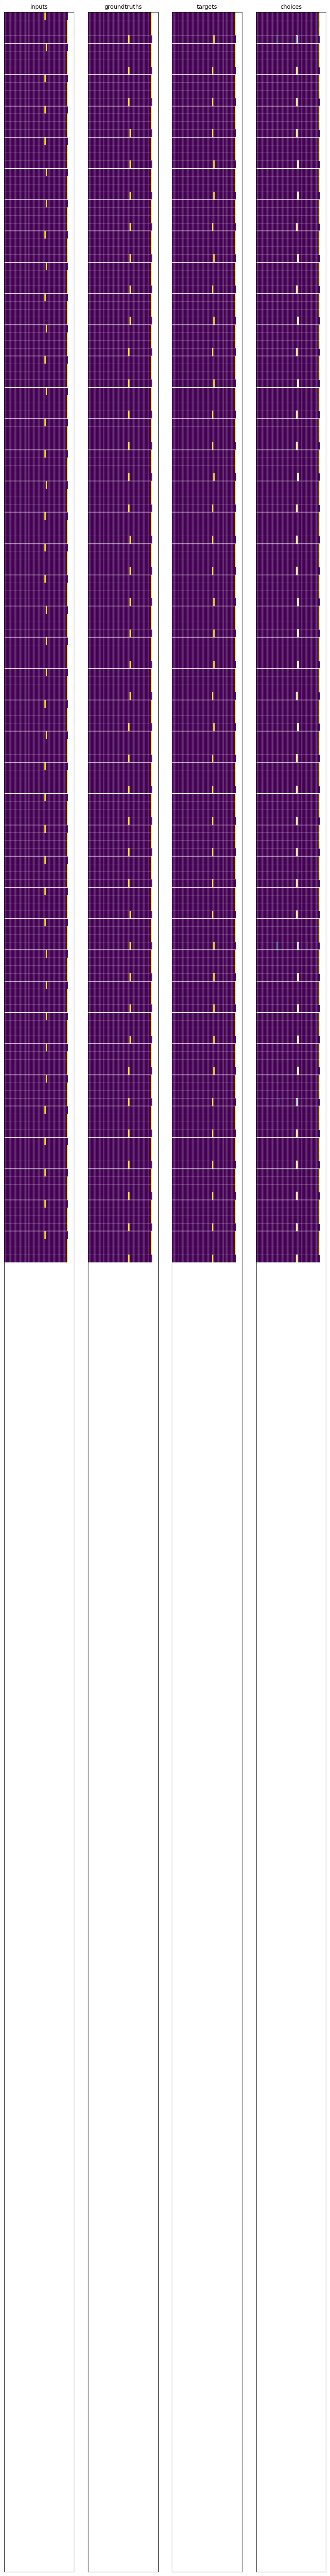

In [663]:
import torch

b = 154
num_trials = 80
t = num_trials * Conf.trial_len

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(10, num_trials))

def display_mat(ax, data, title='', highlight=False):
    data = data.clone().numpy() if type(data) == torch.Tensor else data
    ax.imshow(data, aspect='auto', interpolation='none')
    ax.axvline(x=Conf.x_dim-0.5, c='w', linewidth=1)
    ax.axvline(x=Conf.r_dim + Conf.x_dim-0.5, c='w', linewidth=1)
    for i in range(1, t//Conf.trial_len + 1):
        ax.axhline(y=i * Conf.trial_len-0.5, c='w', linewidth=1)
    ax.set_title(title, fontsize=10)

    if highlight:
        for i, choice in enumerate(np.argmax(data, axis=-1)):
            rect = patches.Rectangle((choice-0.5, i-0.5), 1, 1, linewidth=1, edgecolor='white', facecolor='none')
            axes[3].add_patch(rect)

    # ax.yaxis.set_visible(False)
    # ax.xaxis.set_visible(False)
    # q: how do I turn on the grid on the plot?
    # a: ax.grid(True)
    # q: its not showing up
    # a: try plt.grid(True)
    # q: its still not showing up
    # Set grid
    ax.set_xticks([i+0.5 for i in range(data.shape[1])])  # Adjust x-ticks to align with grid
    ax.set_yticks([i+0.5 for i in range(data.shape[0])])  # Adjust y-ticks to align with grid
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax.grid(True, which='both', color='white', alpha=0.3, linestyle='-', linewidth=0.5)

a_idx = Conf.x_dim + Conf.r_dim
display_mat(axes[0], inputs[b, :t, a_idx:], title='inputs')
display_mat(axes[1], ground_truth[b, :t, a_idx:], title='groundtruths')
display_mat(axes[2], targets[b, :t, a_idx:], title='targets')
display_mat(axes[3], choices[b, :t, a_idx:], title='choices', highlight=True)
# display_mat(axes[3], softmax(choices[b, :t, a_idx:], axis=-1), title='choices')
print(np.argmax(choices[b, :t, a_idx:], axis=-1))

In [908]:
accuracies_action, _, chance, _ = train_decoders(hiddens, targets=action, layouts=layouts, exclude_batch_idxs=None, T=20, multi_class='ovr', max_iter=200, random_state=42)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]
20
Using multiclass: True


  0%|          | 0/20 [00:00<?, ?it/s]

(10000, 512) (10000,)


  5%|▌         | 1/20 [00:03<01:01,  3.24s/it]

(10000, 512) (10000,)


 10%|█         | 2/20 [00:08<01:23,  4.63s/it]

(10000, 512) (10000,)


 15%|█▌        | 3/20 [00:11<01:02,  3.66s/it]

(10000, 512) (10000,)


 20%|██        | 4/20 [00:14<00:52,  3.28s/it]

(10000, 512) (10000,)


 25%|██▌       | 5/20 [00:16<00:43,  2.90s/it]

(10000, 512) (10000,)


 30%|███       | 6/20 [00:18<00:36,  2.62s/it]

(10000, 512) (10000,)


 35%|███▌      | 7/20 [00:20<00:31,  2.40s/it]

(10000, 512) (10000,)


 40%|████      | 8/20 [00:22<00:27,  2.31s/it]

(10000, 512) (10000,)


 45%|████▌     | 9/20 [00:24<00:25,  2.35s/it]

(10000, 512) (10000,)


 50%|█████     | 10/20 [00:26<00:22,  2.26s/it]

(10000, 512) (10000,)


 55%|█████▌    | 11/20 [00:29<00:19,  2.22s/it]

(10000, 512) (10000,)


 60%|██████    | 12/20 [00:31<00:17,  2.19s/it]

(10000, 512) (10000,)


 65%|██████▌   | 13/20 [00:33<00:15,  2.28s/it]

(10000, 512) (10000,)


 70%|███████   | 14/20 [00:35<00:13,  2.24s/it]

(10000, 512) (10000,)


 75%|███████▌  | 15/20 [00:37<00:11,  2.23s/it]

(10000, 512) (10000,)


 80%|████████  | 16/20 [00:40<00:08,  2.22s/it]

(10000, 512) (10000,)


 85%|████████▌ | 17/20 [00:42<00:07,  2.35s/it]

(10000, 512) (10000,)


 90%|█████████ | 18/20 [00:45<00:04,  2.33s/it]

(10000, 512) (10000,)


 95%|█████████▌| 19/20 [00:47<00:02,  2.34s/it]

(10000, 512) (10000,)


100%|██████████| 20/20 [00:49<00:00,  2.49s/it]


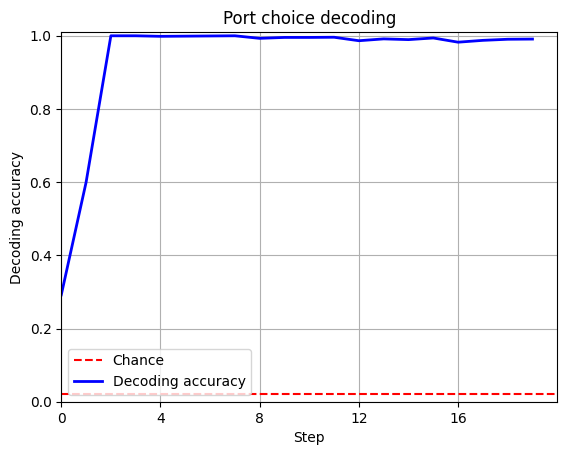

In [909]:
plot_decoding_accuracy(accuracies_action, n_class=Conf.port_dim, title='Port choice decoding')

In [836]:
# Swap the unique elements in the action array
not_action = swap_unique_elements(action, layouts)
print(not_action.shape)

print(not_action[0,:20])
print(action[0,:20])

accuracies_not_action, conf_matrices_not_action, data = train_decoders(hiddens, targets=not_action, layouts=layouts, exclude_batch_idxs=anomalous_idxs, T=20, multi_class='ovr', max_iter=200, random_state=42)

(10000, 160)
[50 50 50 50 37 37 37 37 37 37 37 37 37 37 37 37 18 18 18 18]
[50 50 50 50  1  1  1  1  1  1  1  1  1  1  1  1 18 18 18 18]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]
20
Using multiclass: True


  0%|          | 0/20 [00:00<?, ?it/s]

(4903, 512) (4903,)


  5%|▌         | 1/20 [00:01<00:32,  1.73s/it]

(4903, 512) (4903,)


 10%|█         | 2/20 [00:04<00:42,  2.35s/it]

(4903, 512) (4903,)


 15%|█▌        | 3/20 [00:05<00:31,  1.88s/it]

(4903, 512) (4903,)


 20%|██        | 4/20 [00:07<00:27,  1.73s/it]

(4903, 512) (4903,)


 25%|██▌       | 5/20 [00:08<00:22,  1.49s/it]

(4903, 512) (4903,)


 30%|███       | 6/20 [00:09<00:18,  1.32s/it]

(4903, 512) (4903,)


 35%|███▌      | 7/20 [00:10<00:16,  1.27s/it]

(4903, 512) (4903,)


 40%|████      | 8/20 [00:12<00:16,  1.37s/it]

(4903, 512) (4903,)


 45%|████▌     | 9/20 [00:13<00:14,  1.29s/it]

(4903, 512) (4903,)


 50%|█████     | 10/20 [00:14<00:12,  1.22s/it]

(4903, 512) (4903,)


 55%|█████▌    | 11/20 [00:15<00:11,  1.24s/it]

(4903, 512) (4903,)


 60%|██████    | 12/20 [00:16<00:10,  1.27s/it]

(4903, 512) (4903,)


 65%|██████▌   | 13/20 [00:18<00:08,  1.23s/it]

(4903, 512) (4903,)


 70%|███████   | 14/20 [00:19<00:07,  1.19s/it]

(4903, 512) (4903,)


 75%|███████▌  | 15/20 [00:20<00:06,  1.22s/it]

(4903, 512) (4903,)


 80%|████████  | 16/20 [00:21<00:05,  1.26s/it]

(4903, 512) (4903,)


 85%|████████▌ | 17/20 [00:22<00:03,  1.23s/it]

(4903, 512) (4903,)


 90%|█████████ | 18/20 [00:24<00:02,  1.19s/it]

(4903, 512) (4903,)


 95%|█████████▌| 19/20 [00:25<00:01,  1.19s/it]

(4903, 512) (4903,)


100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


ValueError: too many values to unpack (expected 3)

[188 399]
[39 39 39 39 39 39 39 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1  0]


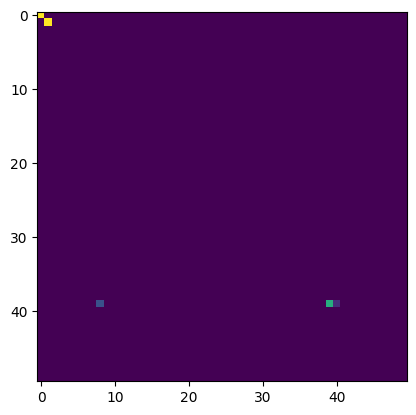

In [678]:
layouts_test, y_trues, y_preds = data
layouts = x_arg_trial[:,0,1:3]
template = np.array([0,1])
result = np.all(layouts_test == template, axis=1)
idxs = np.where(result)[0]
print(idxs)

y_true = y_trues[:, idxs].flatten()
y_pred = y_preds[:, idxs].flatten()

print(y_true)

plt.imshow(confusion_matrix(y_true, y_pred, labels=np.arange(Conf.port_dim), normalize='true'))

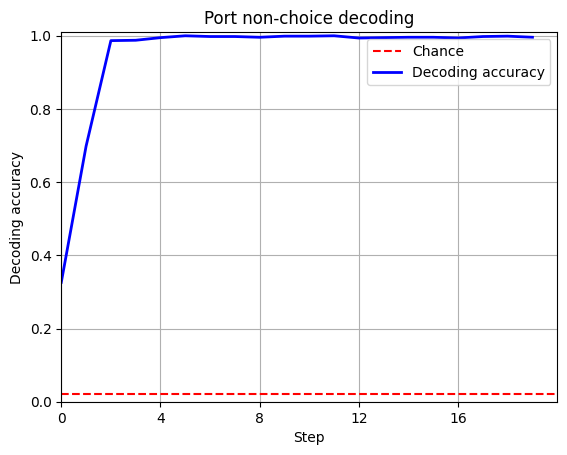

In [679]:
plot_decoding_accuracy(accuracies_not_action, n_class=Conf.port_dim, title='Port non-choice decoding')

In [720]:
bins.shape
i = non_anomalous_idxs[0]
print(np.unique(bins[:,5]))

[ 5 17 32 44]


In [878]:
n_p_bins = 50
bin_edges = np.linspace(0, 1, n_p_bins+1)[1:]  # Creates 5 edges for 4 bins
bins = np.digitize(p_A, bin_edges).squeeze()
bins = np.repeat(bins, Conf.trial_len, axis=-1)
accuracies_p_bins, conf_matrices_p_bins, chance_p_bins, data = train_decoders(hiddens, targets=bins, layouts=layouts, n_class=n_p_bins, exclude_batch_idxs=non_anomalous_idxs, T=40, multi_class='ovr', max_iter=1000, random_state=42)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
40
Using multiclass: True


  0%|          | 0/40 [00:00<?, ?it/s]

(5097, 512) (5097,)
(5097, 512) (5097,)


  8%|▊         | 3/40 [00:00<00:05,  7.12it/s]

(5097, 512) (5097,)
(5097, 512) (5097,)


 10%|█         | 4/40 [00:00<00:06,  5.60it/s]

(5097, 512) (5097,)


 12%|█▎        | 5/40 [00:01<00:11,  3.01it/s]

(5097, 512) (5097,)


 15%|█▌        | 6/40 [00:01<00:14,  2.28it/s]

(5097, 512) (5097,)


 18%|█▊        | 7/40 [00:02<00:17,  1.86it/s]

(5097, 512) (5097,)


 20%|██        | 8/40 [00:03<00:21,  1.47it/s]

(5097, 512) (5097,)


 22%|██▎       | 9/40 [00:04<00:26,  1.19it/s]

(5097, 512) (5097,)


 25%|██▌       | 10/40 [00:06<00:31,  1.06s/it]

(5097, 512) (5097,)


 28%|██▊       | 11/40 [00:07<00:33,  1.17s/it]

(5097, 512) (5097,)


 30%|███       | 12/40 [00:09<00:38,  1.38s/it]

(5097, 512) (5097,)


 32%|███▎      | 13/40 [00:11<00:42,  1.57s/it]

(5097, 512) (5097,)


 35%|███▌      | 14/40 [00:14<00:47,  1.83s/it]

(5097, 512) (5097,)


 38%|███▊      | 15/40 [00:16<00:51,  2.05s/it]

(5097, 512) (5097,)


 40%|████      | 16/40 [00:20<00:59,  2.47s/it]

(5097, 512) (5097,)


 42%|████▎     | 17/40 [00:22<00:58,  2.54s/it]

(5097, 512) (5097,)


 45%|████▌     | 18/40 [00:26<01:01,  2.77s/it]

(5097, 512) (5097,)


 48%|████▊     | 19/40 [00:29<01:02,  2.97s/it]

(5097, 512) (5097,)


 50%|█████     | 20/40 [00:34<01:09,  3.47s/it]

(5097, 512) (5097,)


 52%|█████▎    | 21/40 [00:37<01:04,  3.38s/it]

(5097, 512) (5097,)


 55%|█████▌    | 22/40 [00:41<01:02,  3.47s/it]

(5097, 512) (5097,)


 57%|█████▊    | 23/40 [00:45<01:02,  3.65s/it]

(5097, 512) (5097,)


 60%|██████    | 24/40 [00:50<01:06,  4.15s/it]

(5097, 512) (5097,)


 62%|██████▎   | 25/40 [00:53<00:58,  3.91s/it]

(5097, 512) (5097,)


 65%|██████▌   | 26/40 [00:57<00:54,  3.91s/it]

(5097, 512) (5097,)


 68%|██████▊   | 27/40 [01:01<00:50,  3.91s/it]

(5097, 512) (5097,)


 70%|███████   | 28/40 [01:06<00:50,  4.21s/it]

(5097, 512) (5097,)


 72%|███████▎  | 29/40 [01:09<00:43,  3.92s/it]

(5097, 512) (5097,)


 75%|███████▌  | 30/40 [01:13<00:38,  3.88s/it]

(5097, 512) (5097,)


 78%|███████▊  | 31/40 [01:17<00:34,  3.88s/it]

(5097, 512) (5097,)


 80%|████████  | 32/40 [01:22<00:34,  4.29s/it]

(5097, 512) (5097,)


 82%|████████▎ | 33/40 [01:25<00:27,  3.95s/it]

(5097, 512) (5097,)


 85%|████████▌ | 34/40 [01:29<00:23,  3.94s/it]

(5097, 512) (5097,)


 88%|████████▊ | 35/40 [01:33<00:19,  3.94s/it]

(5097, 512) (5097,)


 90%|█████████ | 36/40 [01:38<00:17,  4.27s/it]

(5097, 512) (5097,)


 92%|█████████▎| 37/40 [01:41<00:11,  3.93s/it]

(5097, 512) (5097,)


 95%|█████████▌| 38/40 [01:45<00:07,  3.93s/it]

(5097, 512) (5097,)


 98%|█████████▊| 39/40 [01:49<00:03,  3.91s/it]

(5097, 512) (5097,)


100%|██████████| 40/40 [01:55<00:00,  2.88s/it]


In [879]:
len(chance_p_bins)

40

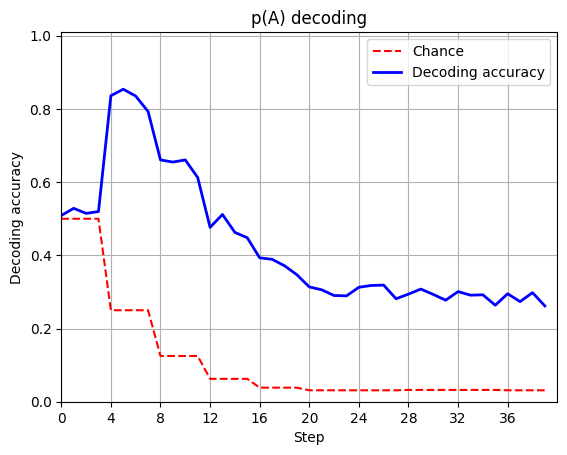

In [880]:
plot_decoding_accuracy(accuracies_p_bins, chance=chance_p_bins, n_class=n_p_bins, title='p(A) decoding')

In [868]:
n_p_bins = 4
bin_edges = np.array([0.2, 0.5, 0.8, 1.0]) #np.linspace(0, 1, n_p_bins+1)[1:]  # Creates 5 edges for 4 bins
bins = np.digitize(np.abs(p_A-0.5) + 0.5, bin_edges).squeeze()
bins = np.repeat(bins, Conf.trial_len, axis=-1)
accuracies_p_bins, conf_matrices_p_bins, chance, data = train_decoders(hiddens, targets=bins, layouts=layouts, n_class=n_p_bins, exclude_batch_idxs=non_anomalous_idxs, T=40, multi_class='ovr', max_iter=1000, random_state=42)

[0 1 2 3]
40
Using multiclass: True


 15%|█▌        | 6/40 [00:00<00:00, 52.12it/s]

(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)


 30%|███       | 12/40 [00:00<00:00, 28.07it/s]

(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)


 40%|████      | 16/40 [00:00<00:00, 25.81it/s]

(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)


 55%|█████▌    | 22/40 [00:00<00:00, 24.01it/s]

(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)


 62%|██████▎   | 25/40 [00:01<00:00, 21.72it/s]

(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)


 78%|███████▊  | 31/40 [00:01<00:00, 22.12it/s]

(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)


 85%|████████▌ | 34/40 [00:01<00:00, 21.02it/s]

(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)


100%|██████████| 40/40 [00:01<00:00, 22.99it/s]

(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)
(5097, 512) (5097,)


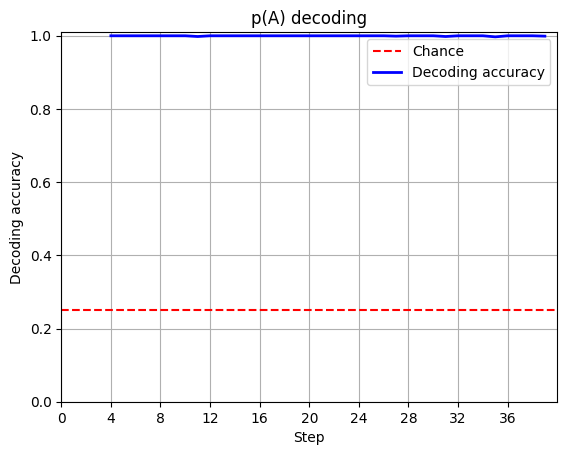

In [869]:
plot_decoding_accuracy(accuracies_p_bins, chance=None, n_class=n_p_bins, title='p(A) decoding')

In [855]:
def mask_conf_mats(conf_mats, bins, n_p_bins, mask='all'):
    if mask not in ['all', 'step']:
        raise ValueError('mask must be "all" or "step"')
    
    if mask == 'all': idx = np.array(list(set(np.arange(n_p_bins)) - set(np.unique(bins))))
    conf_mats_masked = []
    for conf_mat, bin in zip(conf_mats, bins):
        conf_mat_masked = conf_mat.copy()
        if mask == 'step': idx = np.array(list(set(np.arange(n_p_bins)) - set(np.unique(bin))))
        print(idx)
        if len(idx):
            conf_mat_masked[idx,:] = np.nan
            conf_mat_masked[:,idx] = np.nan

        conf_mats_masked.append(conf_mat_masked)
    return conf_mats_masked

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 39 47 48 49]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 39 47 48 49]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 39 47 48 49]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 39 47 48 49]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 39 47 48 49]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 39 47 48 49]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 39 47 48 49]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 39 47 48 49]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 39 47 48 49]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 39 47 48 49]
[ 0  1  2 

/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_19463/1471288636.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
/var/folders/lv/jc4t_z1d75n6dp1c2sbbc9xc0000gn/T/ipykernel_19463/1471288636.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


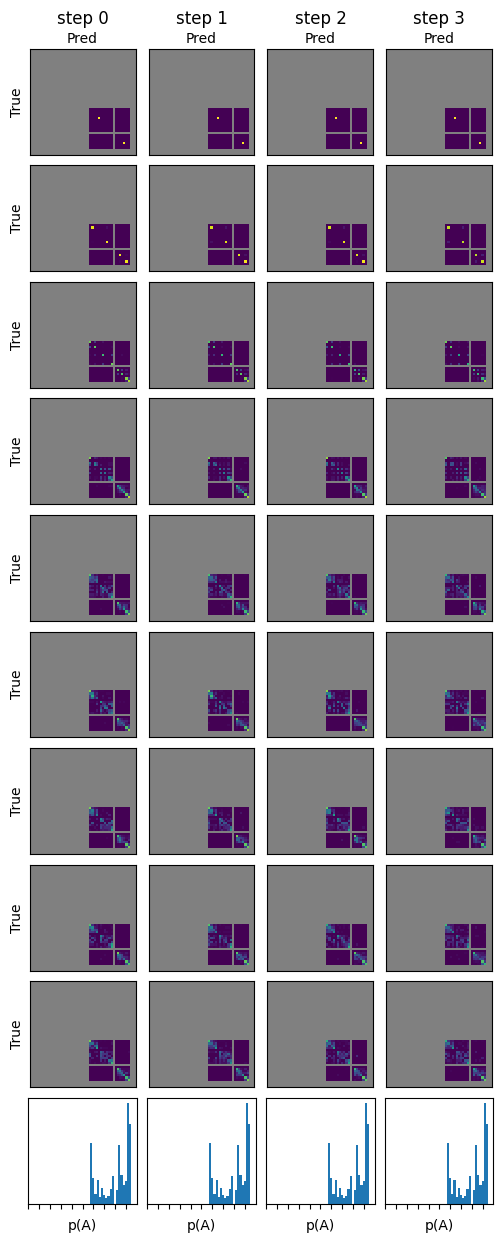

In [856]:
from matplotlib import gridspec

n_row, n_col = len(conf_matrices_p_bins) // Conf.trial_len + 1, Conf.trial_len
fig = plt.figure(figsize=(1.5 * n_col, 1.5 * n_row))
gs = gridspec.GridSpec(n_row, n_col, figure=fig, wspace=0.1, hspace=0.1)

conf_matrices_p_bins_masked = mask_conf_mats(conf_matrices_p_bins, bins, n_p_bins, mask='all')
for i, (m) in enumerate(conf_matrices_p_bins_masked):
    cmap = plt.cm.get_cmap('viridis')
    cmap.set_bad('gray')  # Set the color for NaN values

    ax = fig.add_subplot(gs[i])
    ax.imshow(m, vmin=0, vmax=1, cmap=cmap, interpolation='none')

    if i % Conf.trial_len == 0:
        ax.set_ylabel('True')
    if i // Conf.trial_len == 0:
        ax.set_xlabel('Pred')
        ax.xaxis.set_label_position('top')
        ax.set_title(f'step {i}')

    ax.set_yticks([])
    ax.set_xticks([])

bin_counts = np.bincount(bins.flatten(), minlength=n_p_bins)

for i in range(Conf.trial_len):
    ax = fig.add_subplot(gs[-1, i])
    ax.bar(bin_edges - 0.5 / n_p_bins, bin_counts, width=np.diff(bin_edges, prepend=0), align='edge', capsize=2)
    ax.set_xlim([0, 1])
    ax.set_xlabel('p(A)')
    ax.set_xticks([i / 10 for i in range(10)], [])
    ax.yaxis.set_visible(False)
    if i == 0:
        ax.set_ylabel('count')

plt.tight_layout()


In [790]:
N_step = 40

hiddens_flatten = hiddens[:, :N_step, :].reshape(-1, 1, hiddens.shape[-1])
t_step = np.broadcast_to(np.arange(N_step), (hiddens.shape[0], N_step))
t_step_flatten = t_step.flatten()
layouts_flatten = np.repeat(layouts, hiddens_flatten.shape[0] // hiddens.shape[0], axis=0)
print(hiddens_flatten.shape)
print(t_step_flatten.shape)
print(layouts_flatten.shape)

accuracies_t_step, conf_matrices_t_step, chance, _ = train_decoders(hiddens_flatten, targets=t_step_flatten, layouts=layouts_flatten, T=40, multi_class='ovr', max_iter=1000, random_state=42)

(400000, 1, 512)
(400000,)
(400000, 2)


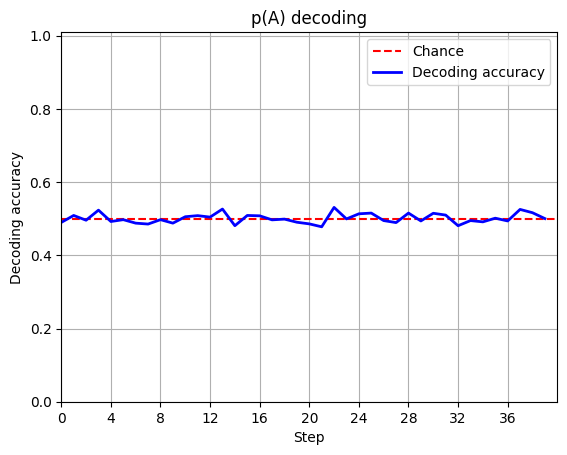

In [383]:
plot_decoding_accuracy(accuracies_p_good, n_class=2, title='p(A) decoding')